# Take-Home Challenge: Ultimate Data Science Challenge

### In this Challenge we will be looking at user and toll data for the cities Gotham and Metropolis.  A brief synopsis of the Challenge can be found here:
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
### We will examine the provided data, cleaning it as well as conducting visualization analysis to look for any trends that may be useful for future feature engineering.  Then we will do some statistical testing on our data based on the hypothesis for this project, create our target feature and run our baseline model.  Based on the results of that baseline model we will then run further models and interpret and present our findings.

#### I will perform this all in one Jupyter notebook for simplicity and for ease of use.  The results will be posted in its according section, with Part 3 at the bottom of the notebook.  Let's get started.

#### As we do with every first step let's read in our data and start by importing some starter libraries to get this exercise off the ground.  We will add to this library list as we go, updating the list to the cell just below here.

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from prophet import Prophet
from sklearn.linear_model import LogisticRegression
from prophet.diagnostics import cross_validation, performance_metrics

In [2]:
# Now let's read in our data files.  They are of json type, so we have to add a few steps to convert to dataframes.
file_path = 'logins.json'

with open(file_path, 'r') as f:
    data = json.load(f)

logins_df = pd.DataFrame(data)

print(logins_df.head())


            login_time
0  1970-01-01 20:13:18
1  1970-01-01 20:16:10
2  1970-01-01 20:16:37
3  1970-01-01 20:16:36
4  1970-01-01 20:26:21


In [3]:
# Now the other file, this one has quite a few more features and data in it.
file_path_ult = 'ultimate_data_challenge.json'

with open(file_path_ult, 'r') as f:
    data_ult = json.load(f)

ult_df = pd.DataFrame(data_ult)

print(ult_df.head())

             city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   

#### Good now let's to some summary review on each of our new dataframes to get an idea of what we are working with.

In [4]:
# Let's look at the logins_df first.
logins_df.shape

(93142, 1)

In [5]:
logins_df.isna().sum()

login_time    0
dtype: int64

In [6]:
logins_df.describe()

,login_time
count,93142
unique,92265
top,1970-01-06 21:45:52
freq,3


## Part 1: Exploratory Data Analysis

#### This dataframe just has one feature in the login_time but it is an important one as this login_time will be used for the entirety of the exercise.  What I don't think we will need though is the actual time stamp.  Let's strip that and keep the date simplified as that is more important for our analysis.  Optional but then let's rename the feature to login_date.  Before we do that though part of the exercise instructions were to do the following: 

Aggregate these login counts based on 15 minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand.  Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

#### Let's do that now before we normalize this feature.

In [7]:
# First let's convert our login_time to datetime for usage.
logins_df['login_time'] = pd.to_datetime(logins_df['login_time'])
logins_df.set_index('login_time', inplace = True)

In [8]:
# Now we assign our pandas resampling task to a new variable for the 15-minute intervals.
login_counts_15min = logins_df.resample('15min').size().reset_index(name = 'login_counts')
print(login_counts_15min.sample(10))

              login_time  login_counts
5338 1970-02-26 10:30:00            13
7008 1970-03-15 20:00:00             6
6447 1970-03-09 23:45:00            10
6526 1970-03-10 19:30:00             9
4265 1970-02-15 06:15:00             7
9079 1970-04-06 09:45:00             7
3347 1970-02-05 16:45:00             2
662  1970-01-08 17:30:00             0
6457 1970-03-10 02:15:00             4
8204 1970-03-28 07:00:00             4


#### Let's also make a count variable for each day, hour, week, and month.  We will then plot them to look for any interesting trends we can see based on these login counts.

In [9]:
# Make the variable for login counts per hour.
login_counts_hour = logins_df.resample('h').size().reset_index(name = 'login_counts')
print(login_counts_hour.sample(10))

              login_time  login_counts
1993 1970-03-25 21:00:00            56
667  1970-01-29 15:00:00            31
1881 1970-03-21 05:00:00            86
1251 1970-02-22 23:00:00            40
2250 1970-04-05 14:00:00            45
2111 1970-03-30 19:00:00            34
1623 1970-03-10 11:00:00            77
57   1970-01-04 05:00:00            51
2162 1970-04-01 22:00:00            81
2142 1970-04-01 02:00:00            44


In [10]:
# Make the variable for login counts per day.
login_counts_day = logins_df.resample('D').size().reset_index(name = 'login_counts')
print(login_counts_day.sample(10))

   login_time  login_counts
78 1970-03-20          1215
74 1970-03-16           837
47 1970-02-17           690
63 1970-03-05           914
84 1970-03-26           873
29 1970-01-30           711
53 1970-02-23           653
41 1970-02-11           719
17 1970-01-18           971
72 1970-03-14          1706


In [11]:
# Now the variable count for week.
login_counts_week = logins_df.resample('W').size().reset_index(name = 'login_counts')
print(login_counts_week.sample(10))

   login_time  login_counts
4  1970-02-01          4744
0  1970-01-04          2374
10 1970-03-15          7338
13 1970-04-05          8095
1  1970-01-11          5217
2  1970-01-18          5023
14 1970-04-12          6491
6  1970-02-15          5915
8  1970-03-01          6554
15 1970-04-19           395


In [12]:
# And finally login counts per month.
login_counts_month = logins_df.resample('ME').size().reset_index(name = 'login_counts')
print(login_counts_month)

  login_time  login_counts
0 1970-01-31         21239
1 1970-02-28         24673
2 1970-03-31         33723
3 1970-04-30         13507


#### Before we start plotting some of these I also want to make counts per each day of the week and for each hour of the day.

In [13]:
# Let's extract the day of the week data first
logins_df['day_of_week'] = logins_df.index.day_name()
logins_by_day_of_week = logins_df.groupby('day_of_week').size().reset_index(name = 'login_counts')

# Sort the days of the week to make output easier to read, we need to put the days in order.
# Will need to make a list of the dow's, create Categorical variables for them then sort accordingly.
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
logins_by_day_of_week['day_of_week'] = pd.Categorical(logins_by_day_of_week['day_of_week'], categories = days_order, ordered = True)
logins_by_day_of_week = logins_by_day_of_week.sort_values('day_of_week')

print(logins_by_day_of_week)

  day_of_week  login_counts
1      Monday          8823
5     Tuesday          9268
6   Wednesday         10339
4    Thursday         11960
0      Friday         15208
2    Saturday         19377
3      Sunday         18167


In [14]:
# And do the same for hour of the day.
logins_df['hour_of_day'] = logins_df.index.hour
logins_by_hour_of_day = logins_df.groupby('hour_of_day').size().reset_index(name = 'login_counts')

print(logins_by_hour_of_day)

    hour_of_day  login_counts
0             0          5993
1             1          6317
2             2          5800
3             3          4831
4             4          5034
5             5          2945
6             6          1138
7             7           815
8             8           818
9             9          1527
10           10          3064
11           11          5799
12           12          4964
13           13          3611
14           14          3426
15           15          3038
16           16          2832
17           17          2584
18           18          2980
19           19          3235
20           20          4103
21           21          5623
22           22          6607
23           23          6058


#### Great now let's look at some quick plots to see what is going on with our login counts.

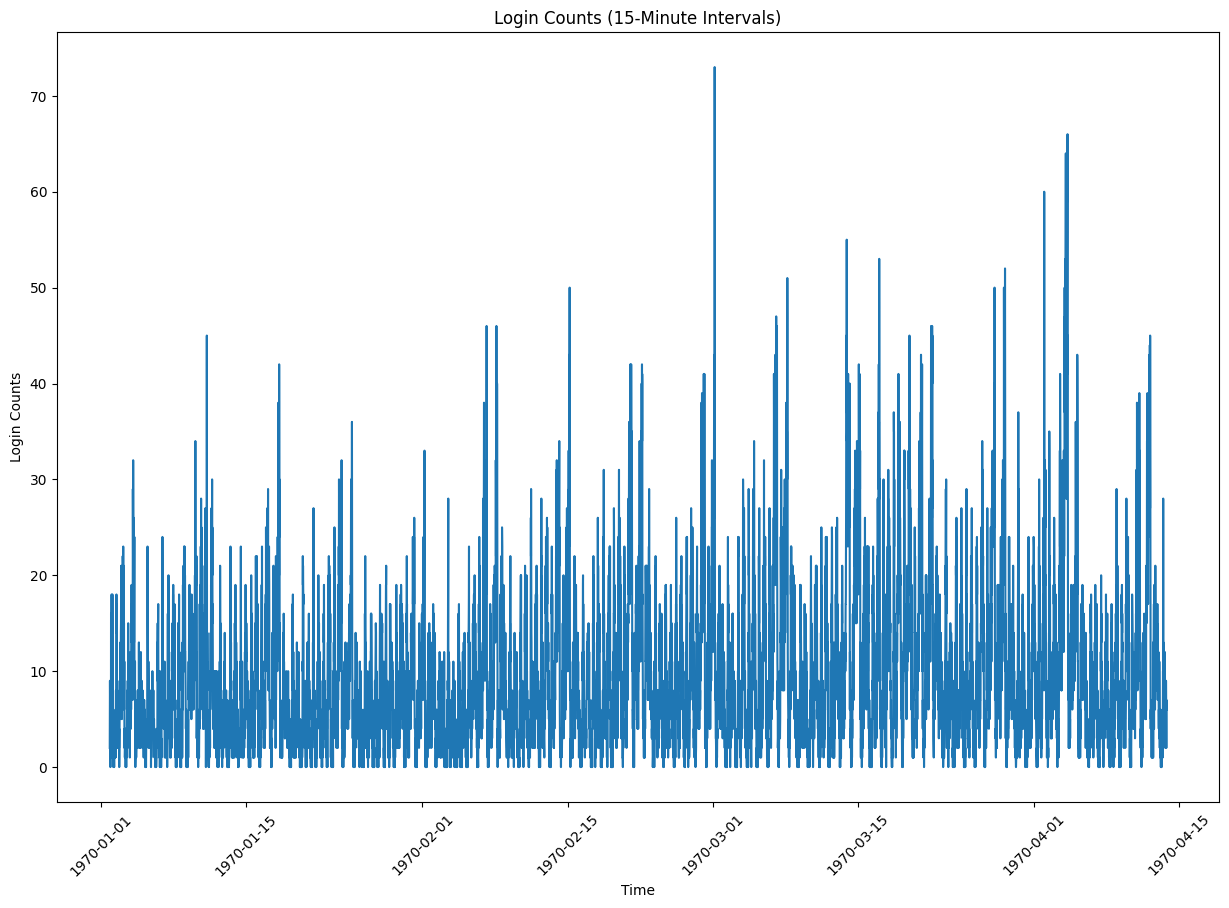

In [15]:
# First the 15min interval plot.
plt.figure(figsize = (15,10))
plt.plot(login_counts_15min['login_time'], login_counts_15min['login_counts'])
plt.title('Login Counts (15-Minute Intervals)')
plt.xlabel('Time')
plt.ylabel('Login Counts')
plt.xticks(rotation = 45)
plt.show()

#### Here above we can see 2 week time invervals and a rough cyclical pattern for our logins for the users.  This plot isn't as clear on our user login activity though, so we will look at some different intervals to see how this activity is better explained.

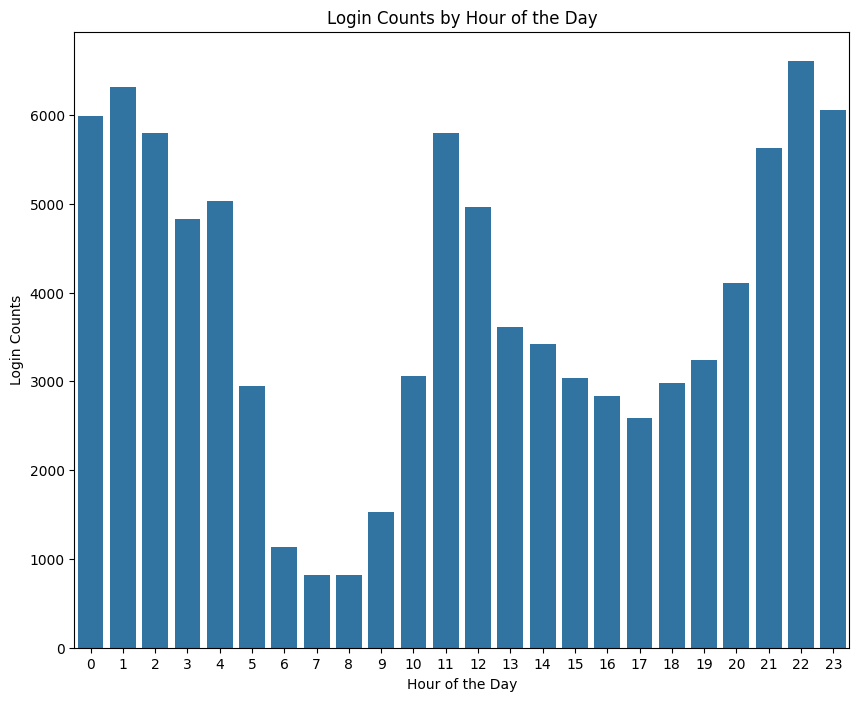

In [16]:
# PLot the user login activity by hour of the day.
plt.figure(figsize = (10,8))
sns.barplot(x = 'hour_of_day', y = 'login_counts', data = logins_by_hour_of_day)
plt.title('Login Counts by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Login Counts')
plt.show()

#### This is a bit better, we can see that user login activity is highest in the middle of the night from 9pm - 5am then a slight spike around lunch time at 11am - 1pm.  Conversely the least amount of login usage is in the morning hours of 6am - 10am.  This is interesting.

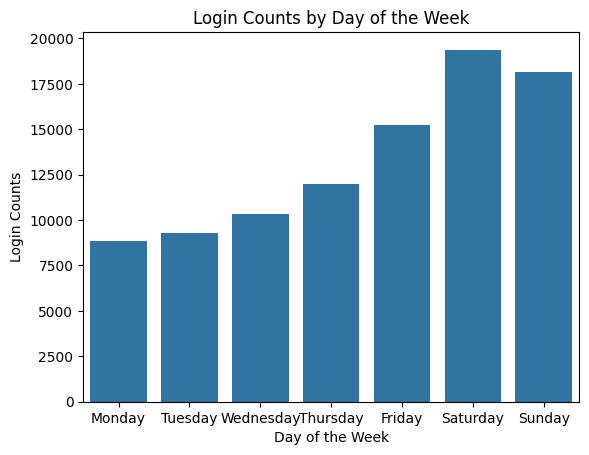

In [17]:
# Now let's plot by day of the week.
plt.plot(figsize = (10,8))
sns.barplot(x = 'day_of_week', y = 'login_counts', data = logins_by_day_of_week)
plt.title('Login Counts by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Login Counts')
plt.show()

#### The bar plot above gives us another clear indicator of our user activity for the login data, telling us over this period that users tend to gradually login more over the course of the week as the week goes by.  The login data grows steadily starting with Monday and hits its peak on Saturday.

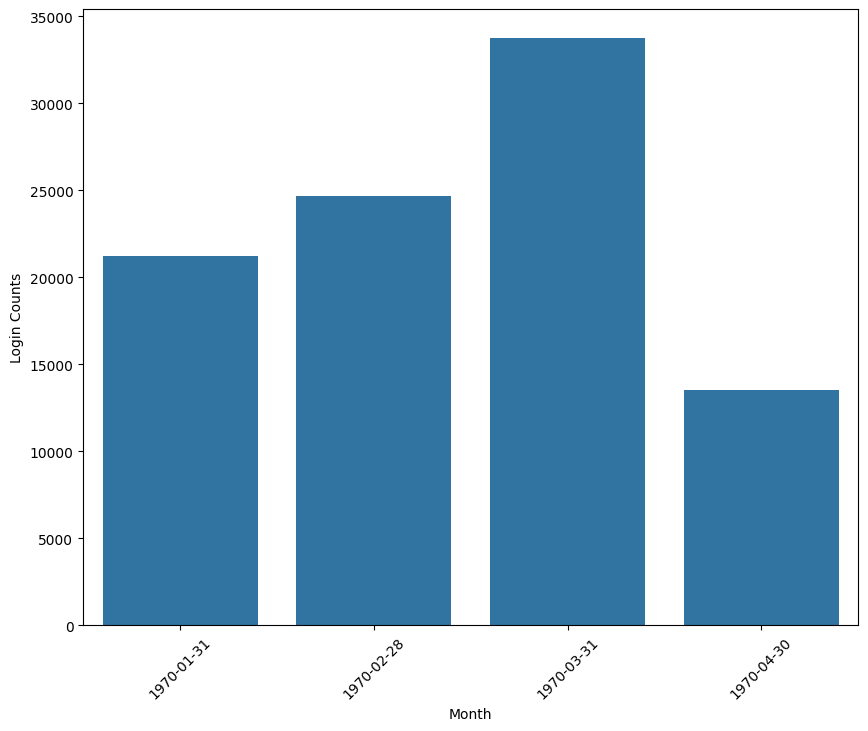

In [18]:
# lets's look at count for each month.
plt.figure(figsize = (10,8))
sns.barplot(x = login_counts_month['login_time'], y = login_counts_month['login_counts'])
title = ('Monthly Login Counts')
plt.xlabel('Month')
plt.ylabel('Login Counts')
plt.xticks(rotation = 45)
plt.show()


#### Now this is interesting, you have a clear picture of the login activity and count increasing from January (first month above) through March, then sharply decreasing in the representative count in April.  Why is this?  Let's keep this in mind as we move along as we work on solving the business problem assigned.

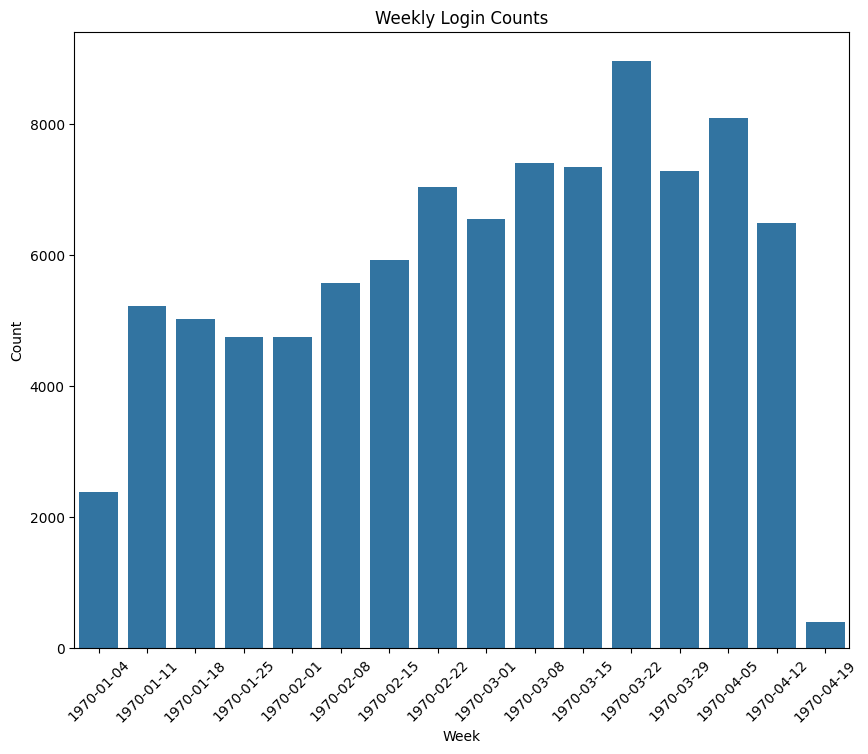

In [19]:
plt.figure(figsize = (10,8))
sns.barplot(x = login_counts_week['login_time'], y = login_counts_week['login_counts'])
plt.title('Weekly Login Counts')
plt.xlabel('Week')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.show()

#### There aren't as many discernible trends in the by-week plot above, however the drop off for login count is much more noticeable here from 04-12 to 04-19 weeks.  Very drastic volume difference.

## Part 1 Summary:
#### We have explored the login data, reading in the json file and converting to a dataframe.  We have looked for missing values (there wasn't any), and then as requested counted logins based on a 15-minute interval and visualized.  Since no real discernible inference was made there we looked at other intervals and noticed the following based on the data presented:

#### -Users had the most login activity on Saturday and Sunday during the week.
#### -Users demonstrated increasing login activity each month from January through March in the data supplied, however there was a sharp decrease in activity in April's reported login data.  This is recommended to be looked into as to why that is.
#### -Users logged in the most during the hours of 9pm - 5am with another spike during lunchtime of 11am - 1pm, and they logged in the least between 6am - 10am.

#### Great, now let's move on to cleaning the other file.

In [20]:
ult_df.shape

(50000, 12)

In [21]:
ult_df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

#### Alright so we have several features that are missing some values, most notably the avg_rating_of_driver feature.  Let's check out at least two of these as since 'phone' is categorical we can fix that one pretty easily.

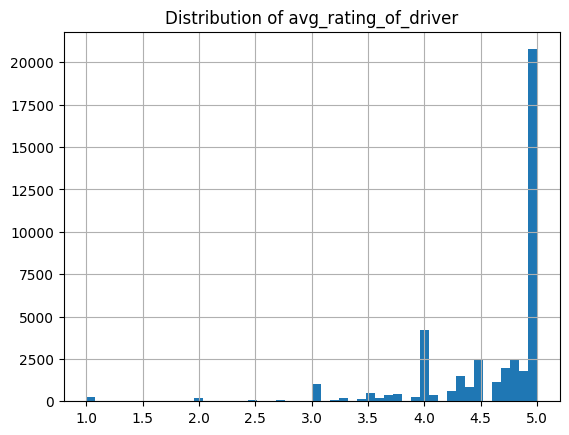

In [22]:
# Set up a quick hist plot to view distribution of the feature.
ult_df['avg_rating_of_driver'].hist(bins = 50)
plt.title('Distribution of avg_rating_of_driver')
plt.show()

#### Since the Distribution is skewed (heavily) we will impute the values with the MEDIAN here.

In [23]:
# After trying to impute with the median once there seems to be a variety of different missing values formats.
# We will look to replace common missing formats with a blanket value nan, so that we can then impute using our median.

ult_df['avg_rating_of_driver'].replace(['', 'Unknown'], np.nan)

ult_df['avg_rating_of_driver'] = ult_df['avg_rating_of_driver'].fillna(ult_df['avg_rating_of_driver'].median())
ult_df['avg_rating_of_driver'].isna().sum()


np.int64(0)

#### Good now let's do the others.  They have just a few missing values but we will approach them the same way.

#### For the 'phone' feature since it is a categorical feature we will just use MODE imputation.

In [24]:
ult_df['phone'].replace(['', 'Unknown'], np.nan)

ult_df['phone'] = ult_df['phone'].fillna(ult_df['phone'].mode()[0])
ult_df['phone'].isna().sum()

np.int64(0)

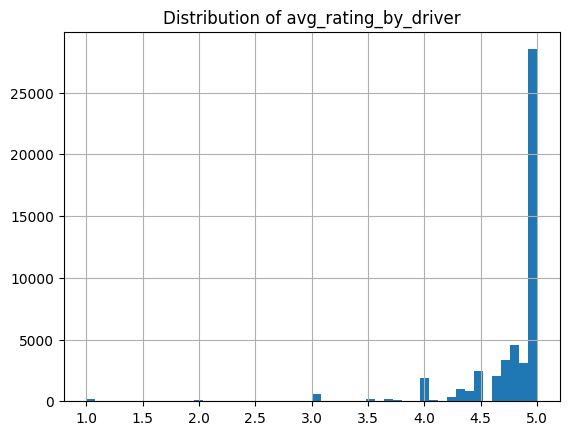

In [25]:
# As we did before let's check out a hist plot for avg_rating_by_driver.
ult_df['avg_rating_by_driver'].hist(bins = 50)
plt.title('Distribution of avg_rating_by_driver')
plt.show()

#### Just like the last hist plot we performed this one is heavily skewed as well, so we shall also perform a MEDIAN imputation on the remaining missing values.

In [26]:
# Use the same format as used before where we assign replacement for np.nan just in case since we have seen other formats.
ult_df['avg_rating_by_driver'].replace(['', 'Unknown'], np.nan)

ult_df['avg_rating_by_driver'] = ult_df['avg_rating_by_driver'].fillna(ult_df['avg_rating_by_driver'].median())
ult_df['avg_rating_by_driver'].isna().sum()


np.int64(0)

#### We have finished cleaning the ult_df dataset now at this point, examining it and imputing missing values with satisfactory methods.  Let's now proceed with part 2 of the exercise.

## Part 2: Experiment and Metrics Design

#### In this section we are given a 'what-if' scenario and asked questions to answer.  Posted below is the script to refer back to:

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1) What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2) Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a) how you will implement the experiment
b) what statistical test(s) you will conduct to verify the significance of the
observation
c) how you would interpret the results and provide recommendations to the city
operations team along with any caveats.
Note: The two cities of Gotham and Metropolis are not in the provided dataset; however, you do
not need this information to answer Part 2.

#### I will answer accordingly with the number and letter that corresponds with the given question.

#### 1.  The first metric that came to mind would be the **percentage increase in cross-city trips**, as since we are talking about two specific cities one on each side of this till bridge and wanting to know how reimbursement of tolls effects resulting bridge crossings, then a metric relating to that seems logical at this time.  Also its very measurable and easily tracked, not only before the toll reimbursement but after.

#### 2.  An experiment I would look to conduct for this scenario would be something like a **RCT (Randomized Control Trial)**, where the drivers would be split into two groups.  One of the groups is a treatment group that receives ful reimbursement for cross-city trips and the other group is a control group that does not receive any reimbursement for their trips.

#### 2a.  I would implement this experiment over a fixed period of time, enough to be able to see results.  I would look to establish this test for at least a month, and maybe a period of at least 90 days so that I can see meaningful changes in user behavior.  In order to prepare for testing I would collect data for cross-city trips for a few weeks before the experiment takes place, and then of course during the experiment.

#### 2b.  For testing I would choose **t-testing** or ANOVA, though likely just t-testing.  I would compare the average number of cross-city trips in the treatment group versus the control group.

#### 2c.  As far as interpreting results I would look at the p-value and its threshold (naturally 0.05), with the base hypothesis that if the p-value is below this threshold than the toll reimbursement does have a statistically significant effect on increasing cross-city trips.  I will also want to examine our key metric we established in our percentage of cross-city trips to see if the reimbursement had any meaningful impact.  For recommendations if there are significant increases in cross-city trips due to the reimbursement I would then recomment implementing the toll reimbursement program to increase driver availability in both cities.  If however there is no significant effect that is observed, other recommendations might be passed such as surge pricing bonuses or guaranteed earnings for cross-city trips.  Such recommendations will need to be looked into further of course.

## Part 3: Predictive Modeling

####

#### Let's pick back up where we left off by taking a look at some basic EDA (Exploratory Data Analysis) on our features to see what they are telling us in our ult_df dataset.  We will look for any trends or comparisons between different sets of the features, with the goal of creating new features and knowing which of our current features will be more important to our model when we get to that stage in the process soon.  We will also create our target feature for part 3 in retention, so we can see how our existing features relate to it.

In [27]:
# Let's make that retention feature now, as we will need to use it for our EDA and any feature engineering going forward.
# This will be defined as the delta difference between the max (last) date in our data and the last trip taken by a user, within 30 days.

# Convert last_trip_date to datetime
ult_df['last_trip_date'] = pd.to_datetime(ult_df['last_trip_date'])

# Find the max 'last_trip_date' in the data
max_trip_date = ult_df['last_trip_date'].max()

# Create retention: users retained if they have taken a trip within 30 days of the max date
ult_df['retained'] = (ult_df['last_trip_date'] >= (max_trip_date - pd.Timedelta(days = 30))).astype('int64')

# print results
print(ult_df[['last_trip_date', 'retained']].head(10))



  last_trip_date  retained
0     2014-06-17         1
1     2014-05-05         0
2     2014-01-07         0
3     2014-06-29         1
4     2014-03-15         0
5     2014-06-06         1
6     2014-01-25         0
7     2014-01-29         0
8     2014-02-01         0
9     2014-01-05         0


#### Great, it looks like our retained target feature is behaving appropriately.  Let's continue with our EDA, examining what existing features work well with our target.  A great place to start is by doing a correlation heatmap as it will tell you some of the relationships between numeric features, but only the numeric features.  Categorical features won't be included in this.  First though we will investigate and handle any outliers in the data so our output is more accurate.

#### Here we will look to cap or winsorize the data, to try to keep all the values while removing the outlier data (by capping the values down to a percentile).  Although we can go through every single feature and customize our bounds, we will just use a general bound here for this exercise and cap 2% (1% from each bound) for a total of 1000 rows capped for our potential outliers.

In [28]:

# Select only the numeric features of our ult_df.
numeric_features = ult_df.select_dtypes(include = [np.number])


# Loop over each numeric feature to detect outliers using the IQR method
for feature in numeric_features.columns:
    lower_bound = numeric_features[feature].quantile(0.05)
    upper_bound = numeric_features[feature].quantile(0.95)

    ult_df[feature] = np.clip(ult_df[feature], lower_bound, upper_bound)

# Look at shape to see if it took effect
print(ult_df.shape)


(50000, 13)


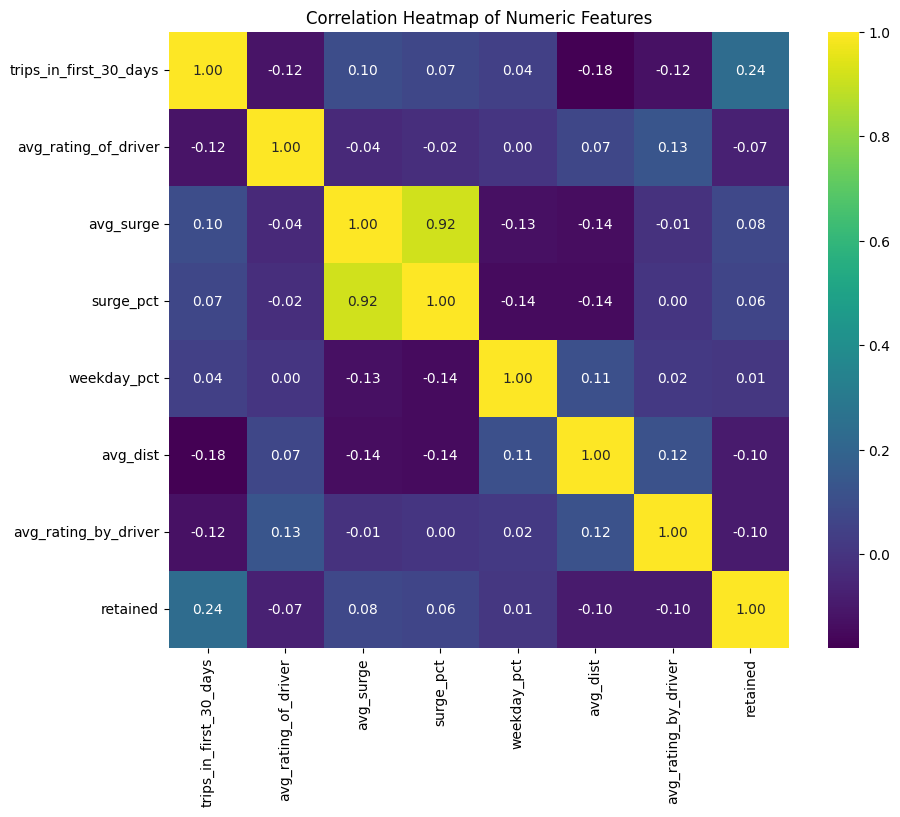

In [29]:
# We need to make sure only the numeric features are included so we don't throw an error.
numeric_df = ult_df.select_dtypes(include = ['float64', 'int64'])

corr_matrix = numeric_df.corr()

plt.figure(figsize = (10,8))
sns.heatmap(corr_matrix, annot = True, cmap = 'viridis', fmt = '.2f')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

#### So the above tells us a few things.  Most of the features in this dataset show correlations close to zero, which means that the features are not linearly related to each other, or rather they are likely independent of one another.  Another observation is that the highest correlation is between the two 'surge' features in avg_surge and surge_pct.  Since they both related to surge pricing and measuring similar things we can review to see if we really need both of these features in our dataset going forward or if we can reduce collinearity by removing one.  Since none of these features are highly correlated we can look to combine some features through feature engineering to create more powerful ones.  We will look into this through the remaining EDA phase as well as exploration on categorical features. 

#### Let's start by looking at some scatter plots between some of the potential for non-linear relationships between our target and some of the other features.

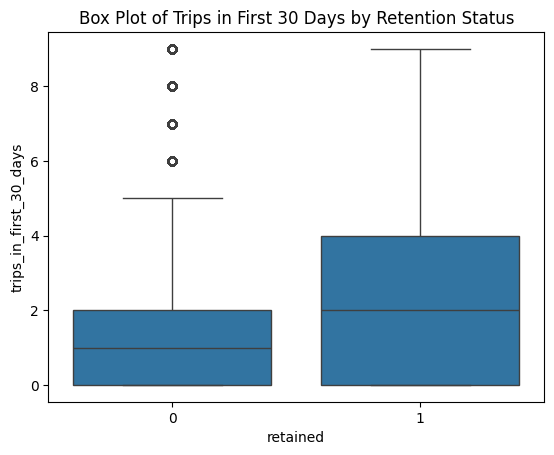

In [30]:
# Box plot between target and trips_in_first_30_days
sns.boxplot(x = 'retained', y = 'trips_in_first_30_days', data = ult_df)
plt.title('Box Plot of Trips in First 30 Days by Retention Status')
plt.show()

#### The above boxplot, outliers aside, shows that retained users take more trips in the first 30 days.  However its still not very definitive.  Let's do some binning on those trip counts to try to capture these relationships.

In [31]:
# Check the new max value after winsorization
max_value = ult_df['trips_in_first_30_days'].max()
print(f"New max value of trips_in_first_30_days after winsorization: {max_value}")

# Binning the trips_in_first_30_days into 3 groups
ult_df['trips_binned'] = pd.cut(ult_df['trips_in_first_30_days'],
                                    bins = [0, 5, 9], 
                                    labels = ['low', 'high'],
                                    include_lowest=True)

# Check the work
print(ult_df['trips_binned'].value_counts())



New max value of trips_in_first_30_days after winsorization: 9
trips_binned
low     44866
high     5134
Name: count, dtype: int64


#### Ah so this is interesting, we see above in our output that the vast majority of our users have taken 0-10 trips in the first 30 days since signing up.  This signals a couple different things.  Basically if a user shows that they will be retained later on they show this sort of activity right away after signing up, with higher trip activity.  Conversely this shows that users who aren't recognized as retained show little to no activity within the first 30 days of signing up.

#### Before we move on we will need to make dummy columns for our trips_binned feature.  This will be needed later when we get to our model.

In [32]:
ult_df = pd.get_dummies(ult_df, columns = ['trips_binned'])

#### This is a good insight, and will help us when we go to our modeling to help make decisions.  Before we make our baseline model though let's take a quick look at our two surge features.  Both of them now correlate really high with our target retention feature so I may need to drop one due to redundancy.  Let's just investigate further before we create our Logistic Regression model.  We will investigate using VIF (Variance Inflation Factor), which scores based on collinearity.

In [33]:
# Need to first add a constant column, which is required for VIF.
X = ult_df[['avg_surge', 'surge_pct']].copy()
X = add_constant(X)

# Calculate the VIF for each feature being looked into for surge.
vif = pd.DataFrame()
vif['Feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

     Feature         VIF
0      const  569.389526
1  avg_surge    6.178574
2  surge_pct    6.178574


#### The const output can be ignored as that is our constant that we created and represents our intercept.  What is interesting is that our two surge features have identical vif scores, in between the 5-10 range.  This shows they have moderate collinearity with our retained target.  Since they also have the exact same correlation score as well at 0.92 I will drop one of these features from the ult_df dataset to reduce complexity.  It doesn't matter which one, but since I want to keep to understanding user behavior and how retained users interact with the surge itself I will keep surge_pct and drop avg_surge.

In [34]:
# Drop avg_surge to reduce complexity and collinearity of the model.
ult_df = ult_df.drop(columns = ['avg_surge'])

#### Alright next we will do some statistical testing to determine if our remaining categorical features are relevant to our model.  We will look at each of city, phone, and ultimate_black_user features to determine if the relationship to our target is valid enough to warrant keeping in our model.

#### Since our remaining features to be tested are all categorical, and our target feature is binary, we will be using chi-squared testing for these and looking at the p-value as a result.

In [35]:
# Run the chi_squared test for the city feature to see how it is relevant.
cont_table_city = pd.crosstab(ult_df['city'], ult_df['retained'])
chi2_city, p_city, dof_city, expected_city = chi2_contingency(cont_table_city)

# Print results, for now just the p-value
print(f"Chi-square test for 'city' vs 'retained' target: p-value = {p_city}")

print(cont_table_city)

Chi-square test for 'city' vs 'retained' target: p-value = 0.0
retained            0     1
city                       
Astapor         12306  4228
King's Landing   3767  6363
Winterfell      15123  8213


#### The p-value of 0.0 shows that the city feature plays a strong role in retention of our users.  We look for anything less than 0.05 here from the p-value.  Since 0.0 is a 'perfect' value I printed the table and you can see that each city representation of its non-retained and retained users show what a difference the city plays in retainage with the splits.  We will keep this feature and create dummy columns for it.  I will then drop the Winterfell dummy column afterwards, as it is population-wise the largest.  Doing so will make Winterfell the reference column and give more meaning to Astapor and King's Landing values, and prohibit perfect multicollinearity from happening with all the newly created dummy city columns being present in the model.

In [36]:
ult_df = pd.get_dummies(ult_df, columns = ['city'])
ult_df = ult_df.drop(columns = ['city_Winterfell'])

#### Great now let's repeat this process for phone feature.

In [37]:
# Run the chi-squared for the phone feature to see how it is relevant.
cont_table_phone = pd.crosstab(ult_df['phone'], ult_df['retained'])
chi2_phone, p_phone, dof_phone, expected_phone = chi2_contingency(cont_table_phone)

# Print results again
print(f"Chi-square test for 'phone' vs retained target: p-value = {p_phone}")

print(cont_table_phone)

Chi-square test for 'phone' vs retained target: p-value = 0.0
retained      0      1
phone                 
Android   11876   3146
iPhone    19320  15658


#### There are only two values in phone feature for Android and iPhone, which means that we won't be dropping either of them as we would lose all the information from both if we did so (same for a binary feature).  Note we also received a 0.0 p-value so this feature is statistically significant, and we will at this time be keeping it with our first iteration of the model, at least until we look at feature importances.  Let's go ahead and create those dummy columns for the phones and separate them.

In [38]:
ult_df = pd.get_dummies(ult_df, columns = ['phone'])

#### Last one let's look at ultimate_black_user.  This one is for sure a binary feature as it denotes a 'yes' or 'no', so its a matter of whether its statistically relevant to our target feature on if we keep it or not.

In [39]:
# Once again run the chi-square test for this feature.
cont_table_ultimate = pd.crosstab(ult_df['ultimate_black_user'], ult_df['retained'])
chi2_ultimate, p_ultimate, dof_ultimate, expected_ultimate = chi2_contingency(cont_table_ultimate)

# Print the results once more
print(f"Chi-square test for 'ultimate_black_user' vs retained target: p-value = {p_ultimate}")

print(cont_table_ultimate)

Chi-square test for 'ultimate_black_user' vs retained target: p-value = 0.0
retained                 0     1
ultimate_black_user             
False                21839  9307
True                  9357  9497


#### Once again our p-value is perfect at 0.0, so we will be keeping this feature for our model here.  What we can infer from the table output though is that for those users who elect into the ultimate_black program about 50% of these users are retained.  Only about 30% of users who do not utilize the ultimate_black program show retainage by definition of our target feature.  This shows that the ultimate_black program, even though we are not given any information on it, has a lot of value to our users that choose to enroll in it.  Let's finish this section by creating our dummy columns and preparing for the model.

In [40]:
ult_df = pd.get_dummies(ult_df, columns = ['ultimate_black_user'])

#### Alright that was some work on our features that weren't time dependent, but let's get some insights on the data that does look into some of the time-dependent data for our users before we engage in feature manipulation work and move on from our EDA phase.

#### First let's look at a plot of trips over time.

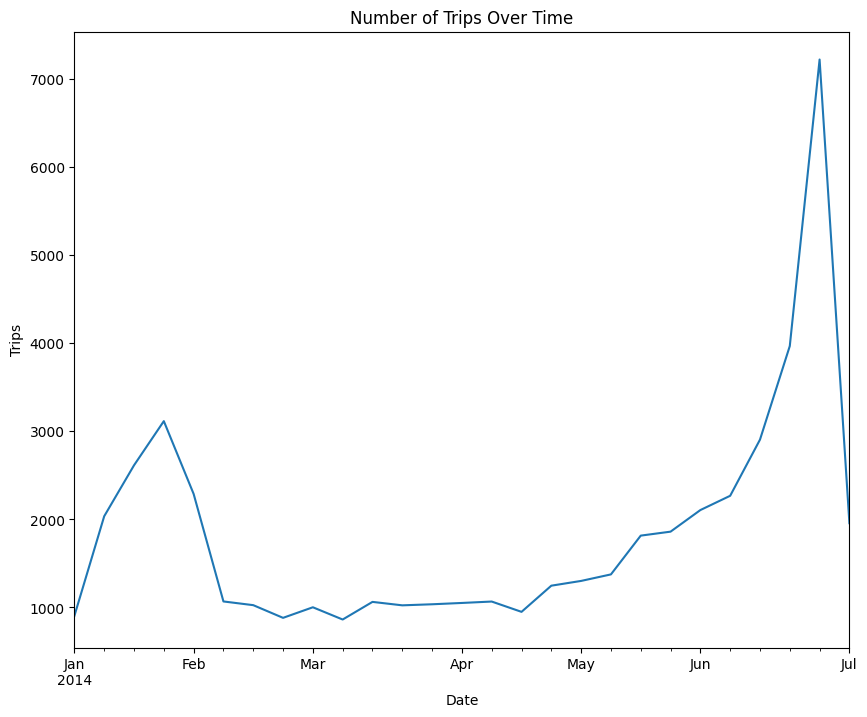

In [41]:
ult_df['trip_count'] = 1 # Adding a column to count each trip
trips_over_time = ult_df.resample('W', on = 'last_trip_date')['trip_count'].sum()

# Now plot the above
plt.figure(figsize = (10,8))
trips_over_time.plot()
plt.title('Number of Trips Over Time')
plt.xlabel('Date')
plt.ylabel('Trips')
plt.show()


#### Here in this straightforward plot we can see trips have a small spike in Jan - Feb and a huge spike in Jun - July.  This could be attributed to vacations for families taken during breaks in summer/winter or especially in summer increased outdoor activity where users are encouraged to travel more.  Let's look at a few more, this next one at the avg_dist (average distance) over time.

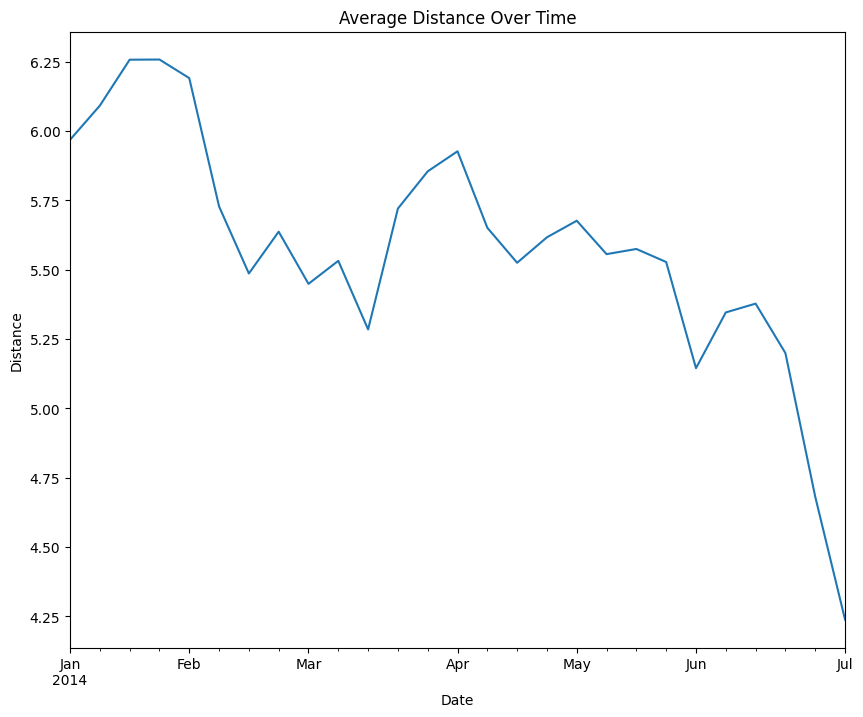

In [42]:
# Plot the average distance travelled over time, in weeks.
avg_distance_over_time = ult_df.resample('W', on = 'last_trip_date')['avg_dist'].mean()

plt.figure(figsize = (10,8))
avg_distance_over_time.plot()
plt.title('Average Distance Over Time')
plt.xlabel('Date')
plt.ylabel('Distance')
plt.show()

#### This is interesting.  Using our knowledge from the previous plot, we can infer that possibly users are travelling longer distances in winter for extended vacations with their families and that the colder weather is inclining them to do so.  The warmer weather in the summer even though we are seeing that as the height of the activity is when our users are showing the shortest distances in their trips, which could be explained by day trips or local visits where they don't need to travel as far.  Let's keep plotting a little and look into surge pricing vs avg distance over time.  This one will be a bit more involved but should give us a bit more insight as well.

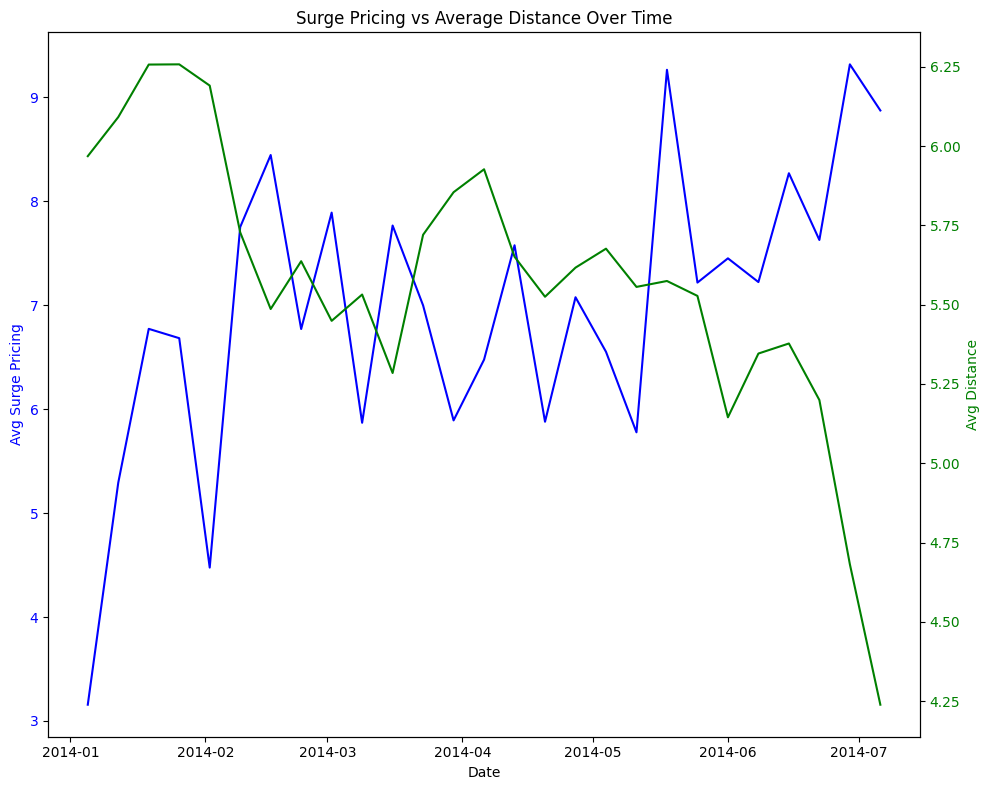

In [43]:
# Resample our two variable by week
ult_df_weekly = ult_df.resample('W', on = 'last_trip_date').agg({
    'surge_pct' : 'mean',
    'avg_dist' : 'mean'
})

# PLot surge pricing vs Average Distance Over Time
fig, ax1 = plt.subplots(figsize = (10,8))

ax1.plot(ult_df_weekly.index, ult_df_weekly['surge_pct'], color = 'blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Avg Surge Pricing', color = 'blue')
ax1.tick_params(axis = 'y', labelcolor = 'blue')

# Second y-axis for avg distance
ax2 = ax1.twinx()
ax2.plot(ult_df_weekly.index, ult_df_weekly['avg_dist'], color = 'green')
ax2.set_ylabel('Avg Distance', color = 'green')
ax2.tick_params(axis = 'y', labelcolor = 'green')

plt.title('Surge Pricing vs Average Distance Over Time')
fig.tight_layout()
plt.show()

#### What we can see in the above is an inverse correlation in early 2014 that as surge pricing (the blue) the average distance of user trips decreases.  This would seem to suggest that users were discouraged from making longer trips when surge pricing was high.  Toward the latter part of our data we can see that the surge pricing is at its highest while the trip distance is at its lowest.  Knowing though that this was when user activity was at its highest too means that users weren't necessarily influenced as much by the surge pricing, so other factors could be influencing their decisions here.

#### We have looked at multiple plots and made quite a few inferences.  Let's move on to feature manipulation where we will filter through our existing features to determine which we will use in our forthcoming modeling.

#### Let's start with RFE (Recursive Feature Elimination) so we can see which features from our existing set are the most valuable.  RFE is model-agnostic and requires a model to have been fit so we will just set up a Logistic Regression model template so we can use it.  First though we will take the step to make last_trip_date into datetime format and set it as our index for the duration of this project.  We also have signup_date, which we will extract value from by transforming it into another feature before removing it.

In [44]:
# Make the changes to last_trip_date
ult_df['last_trip_date'] = pd.to_datetime(ult_df['last_trip_date'])

# Make it the index
ult_df.set_index('last_trip_date', inplace = True)

In [45]:
# Change signup_date to datetime
ult_df['signup_date'] = pd.to_datetime(ult_df['signup_date'])

# Transform this into a new feature = days_since_signup which is in integer format instead
ult_df['days_since_signup'] = (ult_df.index - ult_df['signup_date']).dt.days

# We can now drop the original signup_date feature to avoid future errors
ult_df.drop(columns = ['signup_date'], inplace = True)

In [46]:
# Define a very basic Logistic Regression model for the RFE to run on.
model = LogisticRegression(max_iter = 1000, solver = 'liblinear')

# Set up X and y just like a regular model here
X = ult_df.drop(columns = ['retained'])
y = ult_df['retained']

# Initialize the RFE and fit the model
rfe = RFE(estimator = model, n_features_to_select=6)
rfe.fit(X,y)

# Extract features from the RFE
selected_features_idx = rfe.support_
ranking = rfe.ranking_

# Get the feature names
selected_feature_names = X.columns[selected_features_idx]

# Print results
print("Selected features:", selected_feature_names)
print("Feature Ranking:", ranking)


Selected features: Index(['avg_rating_by_driver', 'trips_binned_high', 'city_King's Landing',
       'phone_iPhone', 'ultimate_black_user_True', 'trip_count'],
      dtype='object')
Feature Ranking: [ 7  8 11 10  9  1  3  1  2  1  4  1  5  1  1  6]


#### In the above output we can see that the RFE process selected the 8 features we requested.  We will take this list and pass it on to the VIF (Variance Inflation Factor) to test them for collinearity.  We will be looking for scores <= 5.0 here.

In [47]:
# We need to first make a new dataframe from our selected_features_idx from the RFE
X_selected_df = ult_df[['avg_rating_by_driver', 'trips_binned_high',
                        'city_King\'s Landing', 'phone_iPhone', 'trip_count',
                        'ultimate_black_user_True']]


In [48]:
# Check types of our new df real quick
X_selected_df.dtypes

avg_rating_by_driver        float64
trips_binned_high              bool
city_King's Landing            bool
phone_iPhone                   bool
trip_count                    int64
ultimate_black_user_True       bool
dtype: object

In [49]:
# Make a copy to avoid warnings
X_selected_df = X_selected_df.copy()

# Anything thats a bool we need to edit to an int64 as VIF will have issues with that.
X_selected_df['trips_binned_high'] = X_selected_df['trips_binned_high'].astype('int64')
X_selected_df['city_King\'s Landing'] = X_selected_df['city_King\'s Landing'].astype('int64')
X_selected_df['phone_iPhone'] = X_selected_df['phone_iPhone'].astype('int64')
X_selected_df['ultimate_black_user_True'] = X_selected_df['ultimate_black_user_True'].astype('int64')

# Check work
print(X_selected_df.dtypes)

avg_rating_by_driver        float64
trips_binned_high             int64
city_King's Landing           int64
phone_iPhone                  int64
trip_count                    int64
ultimate_black_user_True      int64
dtype: object


In [50]:
# Now we can continue and create the VIF DataFrame
vif_data_rfe = pd.DataFrame()
vif_data_rfe['Feature'] = X_selected_df.columns
vif_data_rfe['VIF'] = [variance_inflation_factor(X_selected_df.values, i) for i in range(X_selected_df.shape[1])]

# Print the values from our VIF dataframe
print(vif_data_rfe)

                    Feature         VIF
0      avg_rating_by_driver    1.020008
1         trips_binned_high    1.020781
2       city_King's Landing    1.016082
3              phone_iPhone    1.012605
4                trip_count  278.860397
5  ultimate_black_user_True    1.014922


#### So we are looking for features that have <= 5.0 on the VIF score as that will represent a satisfactory level of collinearity.  All of our features, save obviously trip_count, have an ideal score.  We will drop trip_count and proceed with the remaining 5 features. 

In [51]:
X_selected_df = X_selected_df.drop(columns = ['trip_count'])

#### We will be doing a time-series model(s) using Prophet to guide us through this latter portion of the exercise.  While we could use 5 features in the model it isn't exactly ideal.  I will just select the 3 I believe will be of most value:
- city_King's Landing
- ultimate_black_user_True
- avg_rating_by_driver
#### We could do more analysis however for the sake of time I will select these 3 to continue forward with.

In [59]:
# Here we need to convert last_trip_date back into a column.
ult_df = ult_df.reset_index()

# Make the prophet dataframe
prophet_df = ult_df[['last_trip_date', 'retained', 'city_King\'s Landing',
                    'ultimate_black_user_True', 'avg_rating_by_driver']].copy()

# Rename columns for Prophet for ds and y
prophet_df.rename(columns = {'last_trip_date' : 'ds', 'retained' : 'y'}, inplace = True)

# Instantiate the model
model = Prophet()

# Add our 3 selected features we kept.
model.add_regressor('city_King\'s Landing')
model.add_regressor('ultimate_black_user_True')
model.add_regressor('avg_rating_by_driver')

# Fit the model
model.fit(prophet_df)

21:04:58 - cmdstanpy - INFO - Chain [1] start processing
21:05:54 - cmdstanpy - INFO - Chain [1] done processing


#### Our model is set up, we are now ready to forecast.  In the exercise agenda we need to forecast out 6 months to see if the users will still be considered active.  Let's do that.

In [61]:
# Extend the prediction window out by 6 months (180 days)
future_predictions = model.make_future_dataframe(periods = 180)

# Include the regressors again
future_predictions['city_King\'s Landing'] = prophet_df['city_King\'s Landing']
future_predictions['ultimate_black_user_True'] = prophet_df['ultimate_black_user_True']
future_predictions['avg_rating_by_driver'] = prophet_df['avg_rating_by_driver']

# Forecast the future values
forecast = model.predict(future_predictions)

# Print a sample of the forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
357,2014-12-24,0.917678,-19.068092,21.003902
358,2014-12-25,0.919005,-19.371458,21.137031
359,2014-12-26,0.910001,-19.464655,21.327956
360,2014-12-27,0.900920,-19.672601,21.646702
361,2014-12-28,0.934340,-19.801804,21.952180


#### Now that our forecast is working, let's continue to printing metrics to see how it is performing.  We will look at cross-validation first, then finally a plot to observe.

In [64]:
# Performing cross-validation.
df_cv = cross_validation(model, initial = '150 days', period = '30 days', horizon = '30 days')

# Calculate performance metric
df_p = performance_metrics(df_cv)

# Print metrics
print(df_p)

  0%|          | 0/1 [00:00<?, ?it/s]21:32:02 - cmdstanpy - INFO - Chain [1] start processing
21:32:14 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:15<00:00, 15.84s/it]

   horizon       mse      rmse       mae      mape     mdape     smape  \
0   7 days  0.458357  0.677020  0.675685  0.675685  0.687282  1.023481   
1   8 days  0.444118  0.666422  0.665335  0.665335  0.686360  0.999417   
2   9 days  0.430338  0.656002  0.655090  0.655090  0.651399  0.976142   
3  10 days  0.413564  0.643089  0.642388  0.642388  0.633808  0.947809   
4  11 days  0.393818  0.627549  0.627125  0.627125  0.620104  0.914436   
5  12 days  0.380873  0.617149  0.616863  0.616863  0.611725  0.892515   
6  13 days  0.357616  0.598010  0.597780  0.597780  0.594533  0.853022   
7  14 days  0.313431  0.559849  0.558434  0.558434  0.580153  0.776845   
8  15 days  0.303226  0.550659  0.549509  0.549509  0.545815  0.759339   
9  16 days  0.291866  0.540246  0.539352  0.539352  0.528380  0.739757   
10 17 days  0.276163  0.525512  0.525012  0.525012  0.515223  0.712554   
11 18 days  0.267065  0.516784  0.516545  0.516545  0.514364  0.696713   
12 19 days  0.255854  0.505820  0.5055

#### A bit to go over here.  We can see that as our forecast horizon increases the MSE, RMSE, and MAE generally decrease.  The model also improves around the 28-day mark.  Both MAPE and SMAPE are quite low as well, especially around the 10-day mark.  This suggests that the model is doing a good job of forecasting retention at that horizon.  Coverage, is consistent at 0.0 which means that we aren't calculating or considering uncertainty.  I am not as worried about though in this particular case.  Let's do a new cross-validation with editing the horizon to 15 days, since that seems to be where we had already seen gains in performance.  By shortening the horizon window our metrics should see improvements in most areas.

In [65]:
# Performing cross-validation again with adjusted horizon window of 15 days
df_cv = cross_validation(model, initial = '150 days', period = '30 days', horizon = '15 days')

# Calculate performance metric
df_p = performance_metrics(df_cv)

# Print metrics
print(df_p)

  0%|          | 0/1 [00:00<?, ?it/s]21:44:31 - cmdstanpy - INFO - Chain [1] start processing
21:44:43 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:15<00:00, 15.82s/it]

   horizon       mse      rmse       mae      mape     mdape     smape  \
0   4 days  0.163350  0.404166  0.403056  0.403056  0.413129  0.335193   
1   5 days  0.208768  0.456912  0.456332  0.456332  0.457357  0.371412   
2   6 days  0.298256  0.546128  0.544706  0.544706  0.561304  0.427725   
3   7 days  0.333740  0.577703  0.577356  0.577356  0.581338  0.447928   
4   8 days  0.375301  0.612618  0.611257  0.611257  0.604165  0.467798   
5   9 days  0.451851  0.672198  0.670840  0.670840  0.682617  0.501956   
6  10 days  0.533828  0.730636  0.730304  0.730304  0.732561  0.534866   
7  11 days  0.603561  0.776892  0.776707  0.776707  0.778799  0.559391   
8  12 days  0.677459  0.823079  0.822993  0.822993  0.820617  0.583039   
9  13 days  0.841481  0.917323  0.917246  0.917246  0.914693  0.628821   
10 14 days  0.899405  0.948370  0.948293  0.948293  0.945497  0.643260   
11 15 days  0.956262  0.977886  0.977237  0.977237  0.967965  0.656281   

    coverage  
0        0.0  
1      

#### Scores for out metrics have become noticeably worse overall, so our model is better over a longer horizon.  Looking back at our 30-day horizon output, we can see that day 28 is our best performance.  After that though the metrics get worse.  Seeing this it wouldn't make sense to make another cross-validation run with a larger horizon than 30 days.  We will use a 30-day horizon going forward and note 28 days as our optimum metrics marker.

#### Its finally time to answer the exercise agenda questions.  Here they are below:
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).
#### Let's take care of all of these in order.


In [66]:
# First the users percent that is considered retained.
total_users = len(ult_df)

# Number of retained users
retained_users = ult_df['retained'].sum()

# Percent of retained users
fraction_retained = retained_users / total_users

print(f"Fraction of observed users retained: {fraction_retained:.2f}")

Fraction of observed users retained: 0.38


#### For our first item we can see that 0.38 or 38% of our users are considered as retained as per the way we have calculated it here in this notebook.

#### We set out to build a time series model to help Ultimate determine whether or not a user will be active in their 6th month on the system.

#### Although we attempted a more complex forecasting approach with Prophet, after further review a better approach and model would have been classification with Logistic Regression or Random Forest etc.  However based on the EDA and insights we gathered:

- User activity seems to be influenced by features like city, phone type, ultimate_black_user status, and trips in the first 30 days.

#### By moving forward with a classification model we would be able to generate a probability that a given user will be active based on historical data.

#### Concerns:  There is limited data and from the feature work we have performed so far the selected features don't seem to overwhelmingly effect or impact retention.  This may need further exploration.

#### For the third ask of this exercise, I would recommend the following based on work performed:

- City specific campaigns:  Users in King's Landing showed the highest retention rate.  Targeting those users as well as users in other cities with city-specific promotions could improve engagement.

- We showed that a rate of higher trips within the first 30 days of signing up led to an increaed rate of retention.  Incentivize this with discounts or loyalty points to engage new users.

- Finally through a separate model such as clustering with KMeans dig deeper into the user behavior and segment them into groups and offer cluster-specific discounts and marketing.